# Imports

In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

import kaggle

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Basic Data Analysis

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.set_index("PassengerId", inplace=True)
train_df = shuffle(train_df)
train_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
8830_02,Mars,True,F/1712/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,0.0,0.0,Pon Vloaf,True
7832_01,Mars,False,D/228/S,TRAPPIST-1e,19.0,False,1823.0,36.0,81.0,0.0,0.0,Sumpid Bart,False
1694_01,Earth,True,G/263/S,PSO J318.5-22,31.0,False,0.0,NaN,0.0,0.0,0.0,Iria Chavezalez,True
9134_01,Earth,False,E/601/S,TRAPPIST-1e,13.0,False,590.0,0.0,32.0,363.0,0.0,Therly Leonadorsen,False
0825_01,Earth,True,G/120/P,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,0.0,0.0,Alendy Wardendez,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168_01,Earth,False,F/658/P,TRAPPIST-1e,24.0,False,0.0,7.0,548.0,4.0,0.0,Jaimez Peckerson,True
8147_03,Earth,False,G/1317/P,TRAPPIST-1e,42.0,False,18.0,5.0,470.0,356.0,57.0,Jeroy Pittler,False
0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,Teron Sageng,True


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 8830_02 to 4981_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [5]:
train_df.isna().sum()/8693   # percentage of null

HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

In [6]:
train_df.nunique()

HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [7]:
train_df["RoomService"].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1313.0       1
536.0        1
4119.0       1
276.0        1
3811.0       1
Name: RoomService, Length: 1273, dtype: int64

# Data Wrangling & EDA

#### 1. Create new columns for missing data and perform EDA on missing items

In [8]:
train_df["HomePlanet_missing"] = train_df["HomePlanet"].isna()
train_df["CryoSleep_missing"] = train_df["CryoSleep"].isna()
train_df["Cabin_missing"] = train_df["Cabin"].isna()
train_df["Destination_missing"] = train_df["Destination"].isna()
train_df["Age_missing"] = train_df["Age"].isna()
train_df["VIP_missing"] = train_df["VIP"].isna()
train_df["RoomService_missing"] = train_df["RoomService"].isna()
train_df["FoodCourt_missing"] = train_df["FoodCourt"].isna()
train_df["ShoppingMall_missing"] = train_df["ShoppingMall"].isna()
train_df["Spa_missing"] = train_df["Spa"].isna()
train_df["VRDeck_missing"] = train_df["VRDeck"].isna()
train_df["Name_missing"] = train_df["Name"].isna()

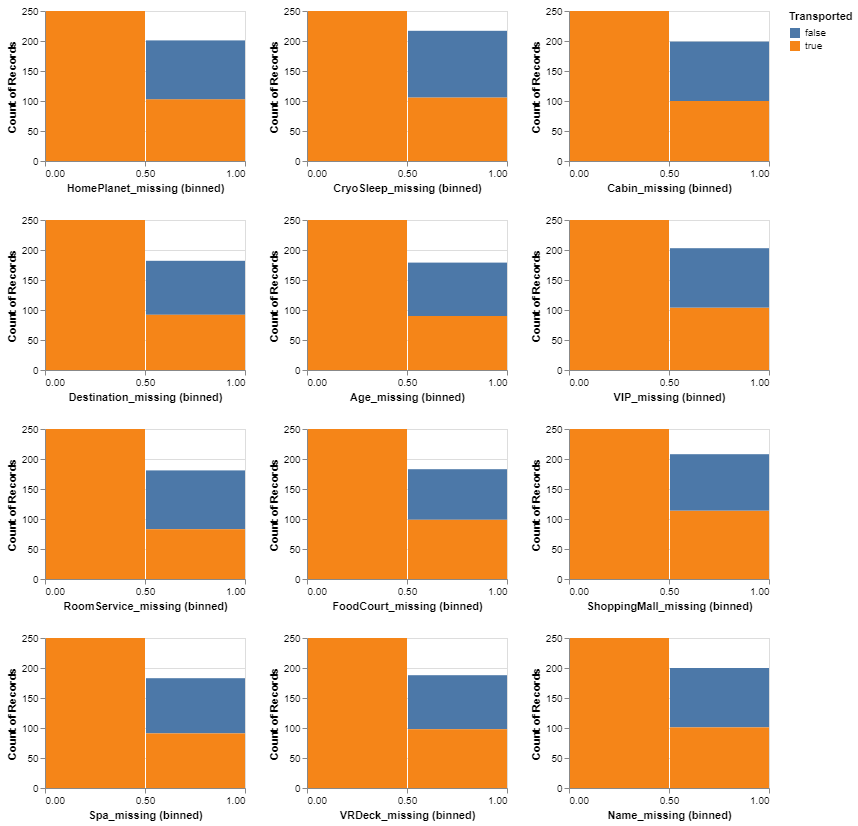

In [9]:
alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=2)),
    alt.Y('count()', scale=alt.Scale(domain=(0, 250))),
    fill='Transported'
).properties(
    width=200,
    height=150
).repeat(
    ["HomePlanet_missing", "CryoSleep_missing", "Cabin_missing",
     "Destination_missing", "Age_missing", "VIP_missing", "RoomService_missing",
     "FoodCourt_missing", "ShoppingMall_missing",
     "Spa_missing", "VRDeck_missing", "Name_missing"],
    columns=3
)

#### 2. Categorical Variables

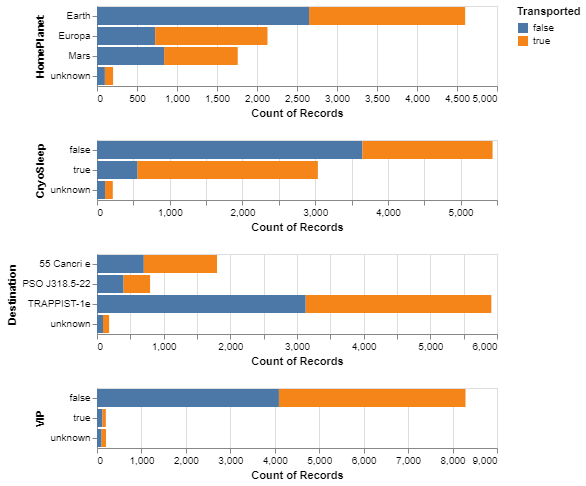

In [10]:
# Replace null with "unknown" and perform EDA

train_df.loc[train_df["HomePlanet"].isna(), "HomePlanet"] = "unknown"
train_df.loc[train_df["CryoSleep"].isna(), "CryoSleep"] = "unknown"
train_df.loc[train_df["Destination"].isna(), "Destination"] = "unknown"
train_df.loc[train_df["VIP"].isna(), "VIP"] = "unknown"

plot_homeplanet = alt.Chart(train_df).mark_bar().encode(
    y="HomePlanet",
    x='count()',
    fill='Transported'
)
plot_cryosleep = alt.Chart(train_df).mark_bar().encode(
    y="CryoSleep",
    x='count()',
    fill='Transported'
)
plot_destination = alt.Chart(train_df).mark_bar().encode(
    y="Destination",
    x='count()',
    fill='Transported'
)
plot_vip = alt.Chart(train_df).mark_bar().encode(
    y="VIP",
    x='count()',
    fill='Transported'
)

plot_homeplanet & plot_cryosleep & plot_destination & plot_vip

#### 3. Wrangling on `Cabin`

In [11]:
# Divide Cabin in to sub 3 section

train_df[['Cabin_dec', 'Cabin_num', 'Cabin_side']] = train_df["Cabin"].str.split("/", expand=True)

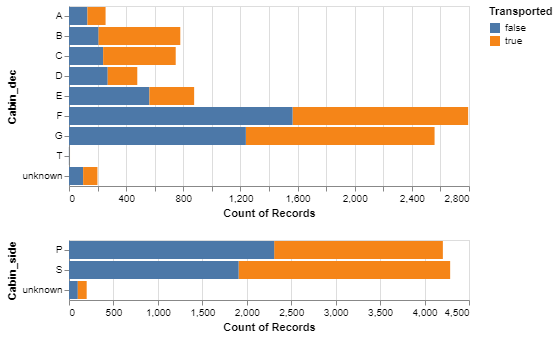

In [12]:
# Replace null with "unknown" and perform EDA

train_df.loc[train_df["Cabin_dec"].isna(), "Cabin_dec"] = "unknown"
train_df.loc[train_df["Cabin_side"].isna(), "Cabin_side"] = "unknown"

plot_cabin_dec = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_dec",
    x='count()',
    fill='Transported'
)
plot_cabin_side = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_side",
    x='count()',
    fill='Transported'
)

plot_cabin_dec & plot_cabin_side

#### 4. Wrangling on `Age`

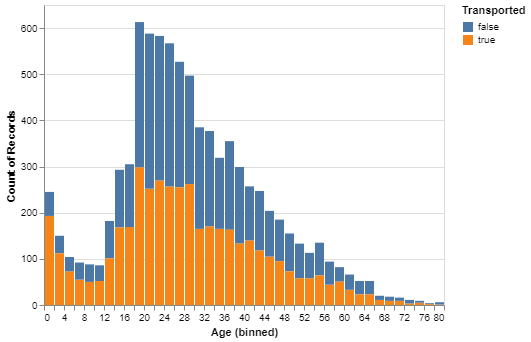

In [13]:
age_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('Age', bin=alt.Bin(maxbins=40)), 
    y='count()',
    fill='Transported')
age_histogram

In [14]:
# Create Age groups

train_df['Age_bin'] = pd.cut(
    train_df['Age'], 
    bins=[0, 12, 18, 30, 50, 66, 90], 
    labels=['Children', 'Teenage', '20s', '30-40s', '50-60s', 'Elder']
)

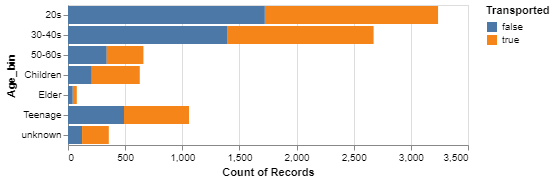

In [15]:
# Replace null with "unknown" and perform EDA

train_df["Age_bin"] = (
    train_df["Age_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_age_bin = alt.Chart(train_df).mark_bar().encode(
    y="Age_bin",
    x='count()',
    fill='Transported'
)
plot_age_bin

#### 5. Wrangling on `RoomService`

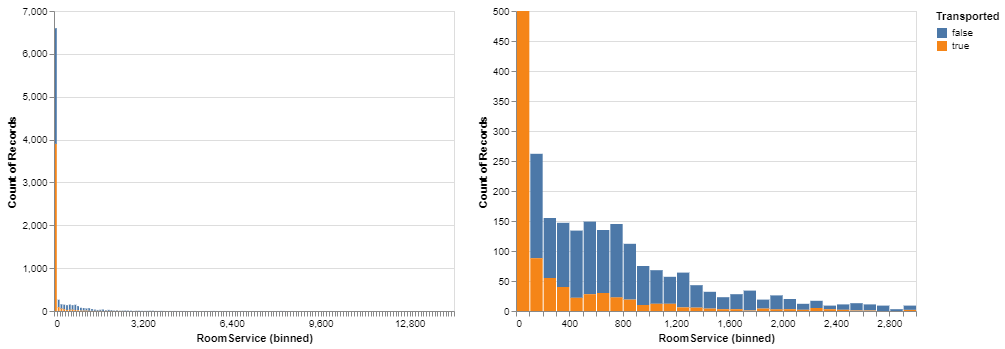

In [16]:
roomservice_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200)), 
    y='count()',
    fill='Transported')
roomservice_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')

roomservice_histogram | roomservice_histogram2

#### 6. Wrangling on `RoomService`

In [17]:
# Create RoomService groups

train_df['RoomService_bin'] = pd.cut(
    train_df['RoomService'], 
    bins=[-100, 0.001, 100, 200, 400, 900, 2400, 15000], 
    labels=['RS$0', 'RS$0-100', 'RS$100-200', 'RS$200-400', 'RS$400-900', 'RS$900-2400', 'RS$2400-15000']
)

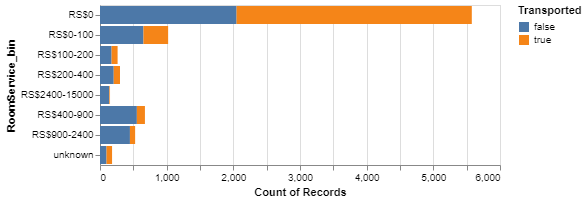

In [18]:
# Replace null with "unknown" and perform EDA

train_df["RoomService_bin"] = (
    train_df["RoomService_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_roomservice_bin = alt.Chart(train_df).mark_bar().encode(
    y="RoomService_bin",
    x='count()',
    fill='Transported'
)
plot_roomservice_bin

#### 7. Wrangling on `FoodCourt`

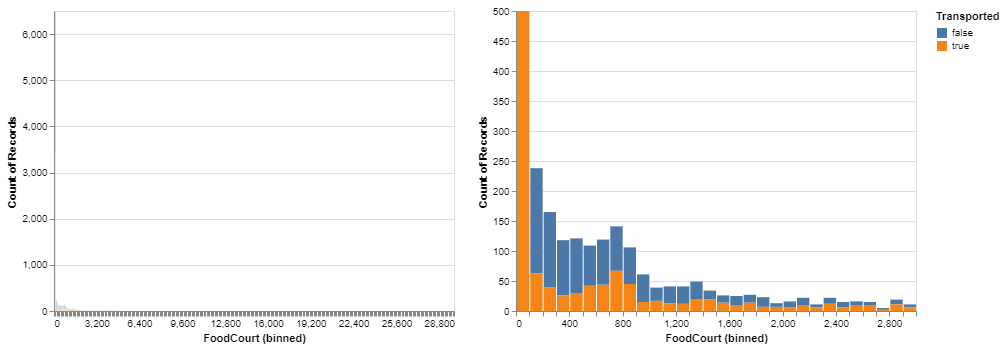

In [19]:
foodcourt_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('FoodCourt', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
foodcourt_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('FoodCourt', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
foodcourt_histogram | foodcourt_histogram2

In [20]:
# Create FoodCourt groups

train_df['FoodCourt_bin'] = pd.cut(
    train_df['FoodCourt'], 
    bins=[-100, 0.001, 100, 500, 900, 2000, 30000], 
    labels=['FC$0', 'FC$0-100', 'FC$100-500', 'FC$500-900', 'FC$900-2000', 'FC$2000-30000']
)

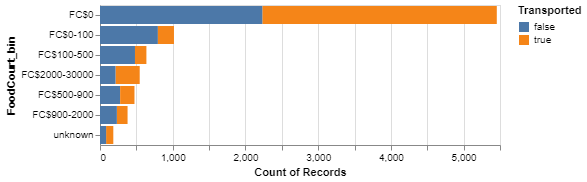

In [21]:
# Replace null with "unknown" and perform EDA

train_df["FoodCourt_bin"] = (
    train_df["FoodCourt_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_roomservice_bin = alt.Chart(train_df).mark_bar().encode(
    y="FoodCourt_bin",
    x='count()',
    fill='Transported'
)
plot_roomservice_bin

#### 8. Wrangling on `ShoppingMall`

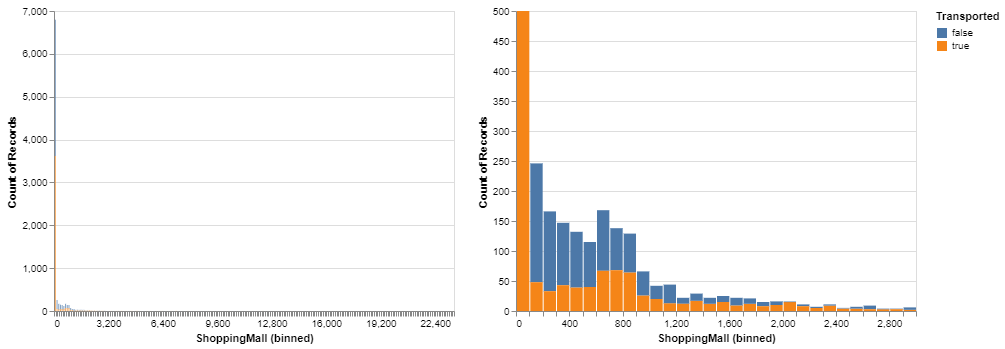

In [22]:
shoppingmall_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('ShoppingMall', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
shoppingmall_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('ShoppingMall', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
shoppingmall_histogram | shoppingmall_histogram2

In [23]:
# Create ShoppingMall groups

train_df['ShoppingMall_bin'] = pd.cut(
    train_df['ShoppingMall'], 
    bins=[-100, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['SM$0', 'SM$0-100', 'SM$100-200', 'SM$200-600', 'SM$600-1200', 'SM$1200-2000', 'SM$2000-30000']
)

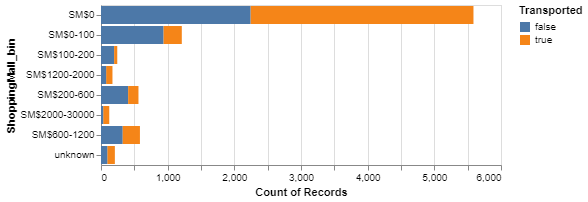

In [24]:
# Replace null with "unknown" and perform EDA

train_df["ShoppingMall_bin"] = (
    train_df["ShoppingMall_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_shoppingmall_bin = alt.Chart(train_df).mark_bar().encode(
    y="ShoppingMall_bin",
    x='count()',
    fill='Transported'
)
plot_shoppingmall_bin

#### 9. Wrangling on `Spa`

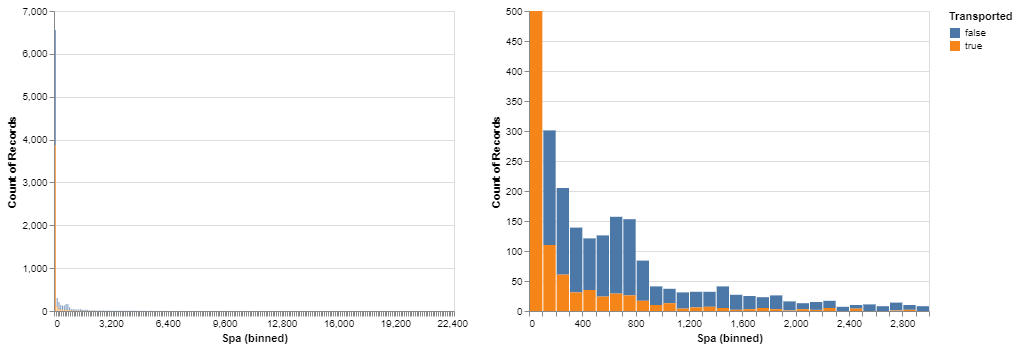

In [25]:
spa_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('Spa', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
spa_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('Spa', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
spa_histogram | spa_histogram2

In [26]:
# Create Spa groups

train_df['Spa_bin'] = pd.cut(
    train_df['Spa'], 
    bins=[-100, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['Sp$0', 'Sp$0-100', 'Sp$100-200', 'Sp$200-600', 'Sp$600-1200', 'Sp$1200-2000', 'Sp$2000-30000']
)

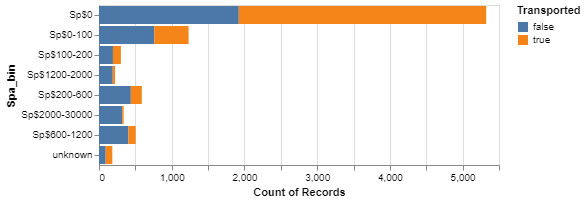

In [27]:
# Replace null with "unknown" and perform EDA

train_df["Spa_bin"] = (
    train_df["Spa_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_spa_bin = alt.Chart(train_df).mark_bar().encode(
    y="Spa_bin",
    x='count()',
    fill='Transported'
)
plot_spa_bin

#### 10. Wrangling on `VRDeck`

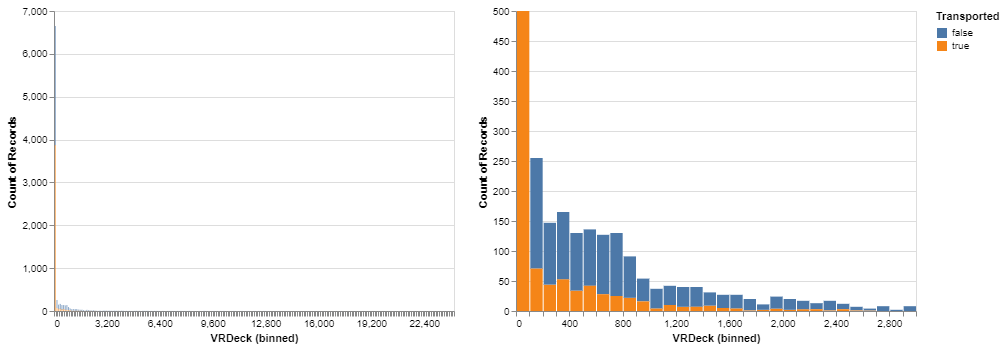

In [28]:
vrdeck_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('VRDeck', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
vrdeck_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('VRDeck', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
vrdeck_histogram | vrdeck_histogram2

In [29]:
# Create VRDeck groups

train_df['VRDeck_bin'] = pd.cut(
    train_df['VRDeck'], 
    bins=[-100, 0.001, 100, 200, 600, 1000, 2000, 30000], 
    labels=['VR$0', 'VR$0-100', 'VR$100-200', 'VR$200-600', 'VR$600-1000', 'VR$1000-2000', 'VR$2000-30000']
)

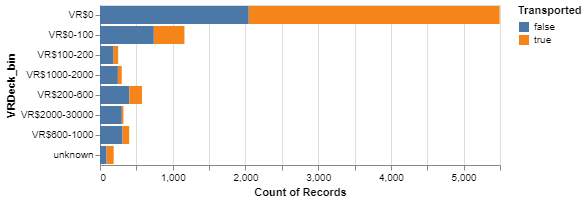

In [30]:
# Replace null with "unknown" and perform EDA

train_df["VRDeck_bin"] = (
    train_df["VRDeck_bin"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_vrdeck_bin = alt.Chart(train_df).mark_bar().encode(
    y="VRDeck_bin",
    x='count()',
    fill='Transported'
)
plot_vrdeck_bin

#### 11. Wrangling on `Name`

In [31]:
train_df["Name"].nunique()

8473

In [32]:
# Split `Name` into first and last names

train_df[['Name_first', 'Name_last']] = train_df["Name"].str.split(" ", expand=True)

In [33]:
train_df["Name_first"].nunique()

2706

In [34]:
train_df["Name_last"].nunique()

2217

In [35]:
train_df["Name_last"].value_counts()

Casonston     18
Oneiles       16
Litthews      15
Domington     15
Browlerson    14
              ..
Inging         1
Stubtlarle     1
Fullided       1
Whetedy        1
Modomel        1
Name: Name_last, Length: 2217, dtype: int64

In [37]:
# Makes a dictionary using the last name and the number of corresponding last names

num_last_name = train_df["Name_last"].value_counts()
last_name_dict = dict(num_last_name)

In [38]:
# Create separate column with the number of the corresponding last names

for name, num in last_name_dict.items():
    train_df.loc[train_df["Name_last"] == name, "num_of_Name_last"] = num

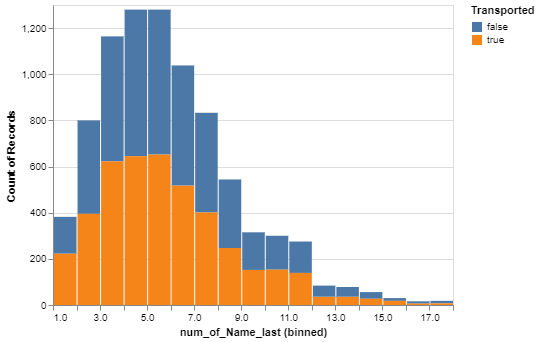

In [39]:
lastname_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('num_of_Name_last', bin=alt.Bin(maxbins=20)), 
    y='count()',
    fill='Transported')
lastname_histogram

In [40]:
# Create groups for number of last name

train_df['num_of_Name_last'] = pd.cut(
    train_df['num_of_Name_last'], 
    bins=[-100, 1.001, 15, 20], 
    labels=['fam1', 'fam2-15', 'fam15-20']
)

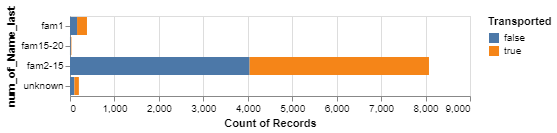

In [41]:
# Replace null with "unknown" and perform EDA

train_df["num_of_Name_last"] = (
    train_df["num_of_Name_last"]
    .cat
    .add_categories('unknown')
    .fillna('unknown')
)

plot_num_lastname = alt.Chart(train_df).mark_bar().encode(
    y="num_of_Name_last",
    x='count()',
    fill='Transported'
)
plot_num_lastname

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 8830_02 to 4981_02
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   HomePlanet            8693 non-null   object  
 1   CryoSleep             8693 non-null   object  
 2   Cabin                 8494 non-null   object  
 3   Destination           8693 non-null   object  
 4   Age                   8514 non-null   float64 
 5   VIP                   8693 non-null   object  
 6   RoomService           8512 non-null   float64 
 7   FoodCourt             8510 non-null   float64 
 8   ShoppingMall          8485 non-null   float64 
 9   Spa                   8510 non-null   float64 
 10  VRDeck                8505 non-null   float64 
 11  Name                  8493 non-null   object  
 12  Transported           8693 non-null   bool    
 13  HomePlanet_missing    8693 non-null   bool    
 14  CryoSleep_missing     8693 non-null   bool    
 15  